In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
%load_ext autoreload
%autoreload 2
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
sns.set_style("white")

In [2]:
import string


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV,LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

# Load data:
For the first part we import the data to get the firts informations about the data.  All the features in the dataset are:
1-id
2-keyword
3-location
4-text
5-target

The random state is taken as 1234

In [37]:
df = pd.read_csv("https://raw.githubusercontent.com/michalis0/DataMining_and_MachineLearning/master/project/training_data.csv")
df.head(20)

,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1
5,6669,landslide,Scotland,FreeBesieged: .MartinMJ22 YouGov Which '#Tory ...,1
6,9772,trapped,New York City,Billionaires have a plan to free half a billio...,0
7,10361,weapons,Multinational *****,@JamesMelville Some old testimony of weapons u...,0
8,1953,burning%20buildings,Los Angeles,Ali you flew planes and ran into burning build...,0
9,9586,thunder,NaN,The thunder shook my house woke my sister and ...,1


In [4]:
df.shape

(6471, 5)

"Alleged driver in #Kuwait attack 'joined Daesh just a day before the June 26 suicide bombing' he confesses in court http://t.co/Tmz6X1N2gQ"

# Target values are composed of 0 and 1. Whether these twits are about a real disaster or not is the focus of the concern.


In [5]:
df.target.unique()

array([0, 1])

In [6]:
#baserate
max(len(df[df["target"] == 0]) / len(df), len(df[df["target"] == 1]) / len(df))

0.5719363313243703

In [7]:
# HOW MANY DİFFERENT IDs, 
df.id.unique().shape
#Ids are unique. 

(6471,)

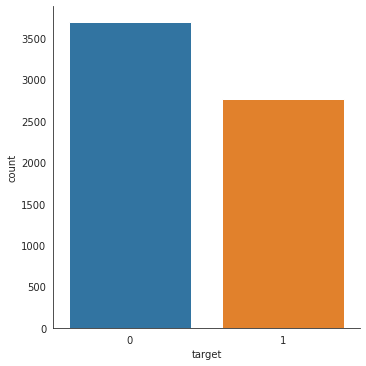

In [8]:
#TARGET 
sns.catplot(x="target", kind="count", data=df);

In [9]:
#missing Values
df.isnull().any()

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [10]:
#missing values in keyword
df.keyword.isnull().value_counts()

False    6416
True       55
Name: keyword, dtype: int64

In [11]:
#missing values in location
df.location.isnull().value_counts()

False    4330
True     2141
Name: location, dtype: int64

In [12]:
#missing values in text
df.text.isnull().value_counts()

False    6471
Name: text, dtype: int64

In [13]:
#missing values in target
df.target.isnull().value_counts()

False    6471
Name: target, dtype: int64

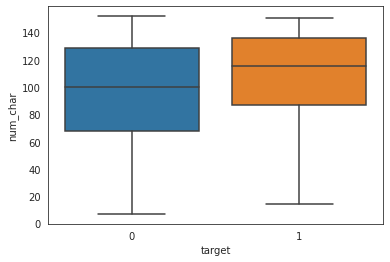

In [14]:
#TEXT LENGTHS
df["num_char"] = df["text"].apply(len)
sns.boxplot(x='target', y='num_char', data=df)

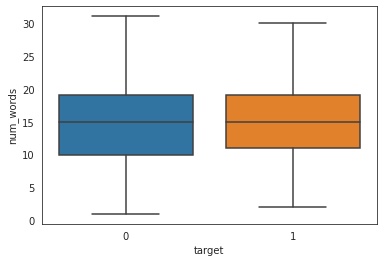

In [15]:
#NUMBER OF WORDS
df["num_words"] = df["text"].apply(lambda x: len(x.split()))
sns.boxplot(x='target', y='num_words', data=df)


In [16]:
#LOCATION ANALYSIS
# Where do most disasters occur / where do disaster tweets come from? 
# Potential problem to take care of: USA and United States are separate; Different US States are also separate;

df.loc[df["target"] == 1, ["location"]].value_counts()

location               
USA                        58
United States              25
Nigeria                    18
India                      18
Mumbai                     17
                           ..
Portage, IN / Worldwide     1
Porthcawl                   1
Portland, OR                1
Portland, Ore.              1
  News                      1
Length: 1323, dtype: int64

##LOCATION-TARGET
Is there a meaningful relation in the  the country level data. i.e: Can we expect that in certain places people are more prone to diffuse fake disaster news:

In [17]:
df2=df[['location','target']].dropna()
print(df2.shape)
X=df['location'].dropna()


(4330, 2)


In [18]:
df['location'].unique().shape

(2922,)

In [19]:
#Categorizing the location 
X.unique().shape # around 3000 unique locations. that would not be a good fature to classify the 

(2921,)

###KEYWORD-TARGET
We can try to analyse the predictability of the keywords on the target. in another words, if for sertain types of disasters, whether people are more accurate, and for certain types people are more prone to hoax.

In [20]:
df3=df[['keyword','target']].dropna()
print("sjhape of df2:", df2.shape)
X=df3['keyword']
y=df3['target']
#How many unique keyword : 221
print(" unique cat in keyword:", X.unique().shape)



sjhape of df2: (4330, 2)
 unique cat in keyword: (221,)


In [21]:
#a label encoding could be used to encode the keywords.
myLabEn = LabelEncoder()
df3_encoded = df3.apply(myLabEn.fit_transform) #
#df3_encoded


In [22]:
#Data prepatation
X=df3_encoded[['keyword']]
y=df3.target

#Splitting train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)


In [23]:
#Fitting
LR=LogisticRegression(solver='lbfgs',  max_iter=1000,random_state=3)
LR.fit(X_train, y_train)

# Accuracy of training set and test set
LR.score(X_train, y_train)

LR.score(X_test, y_test)
print("Accuracy of train and test sets:",LR.score(X_train, y_train), LR.score(X_test, y_test))

Accuracy of train and test sets: 0.5693686671862821 0.5926791277258567


In [24]:
LRcv=LogisticRegressionCV(solver='lbfgs', cv=5,  max_iter=1000,random_state=3)
LRcv.fit(X_train, y_train)

# Accuracy of training set and test set
LRcv.score(X_train, y_train)

LRcv.score(X_test, y_test)
print("Accuracy of train and test sets:",LRcv.score(X_train, y_train), LRcv.score(X_test, y_test))

#It seems the single relationsshipe between keyword and the target is not that meaningful. the accuracy rate is almost near to the base rate. 

Accuracy of train and test sets: 0.5693686671862821 0.5926791277258567


In [25]:
# Predictions
y_pred = LRcv.predict(X_test)
#Confusion matrix
confusion_matrix(y_test, y_pred)
y_pred=pd.DataFrame(y_pred)
#y_pred

#Text Analytics


In [26]:
# Install and update spaCy
!pip install -U spacy

     |████████████████████████████████| 10.0MB 8.0MB/s 
     |████████████████████████████████| 2.1MB 48.9MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [27]:
# Download the english language model
!python -m spacy download en

     |████████████████████████████████| 12.1MB 490kB/s 
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-cp36-none-any.whl size=12047109 sha256=e0e775a1768648ad00a00faeb9145937a0b920bd51e478d735fc74f316c91d8f
  Stored in directory: /tmp/pip-ephem-wheel-cache-dmyrhsog/wheels/2b/3f/41/f0b92863355c3ba34bb32b37d8a0c662959da0058202094f46
Successfully built en-core-web-sm
  Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [28]:
# Import required packages
import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [48]:
# Create a list of punctuation marks
punctuations = string.punctuation


# Create a list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [49]:
punctuations

['!',
 '"',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~']

In [30]:
#LEMMATIZE STOP WORD, PUNCTUATİONS.

# Load English language model
sp = spacy.load('en_core_web_sm')

# Create tokenizer function
def spacy_tokenizer(sentence):
    # Create token object, which is used to create documents with linguistic annotations.

    mytokens = sp(sentence)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    #remove RTs
    #mytokens=[word for word in mytokens if word!='rt' or word[0]!='@' or word[0]!='#'] 
   
    # Return preprocessed list of tokens
    return mytokens

In [43]:
#some Example:
t3=df['text'][3]
t7=df['text'][7]
print(t3)
print("t3-tokenized:", spacy_tokenizer(t3))
print(t7)
print("t7 tokenized:",  spacy_tokenizer(t7))

#Taiwan Grace: expect that large rocks trees mud unstable and/or saturated land may slide ..very hazardous in hilly/mountain areas...
t3- tokenized: ['taiwan', 'grace', 'expect', 'large', 'rock', 'tree', 'mud', 'unstable', 'and/or', 'saturate', 'land', 'slide', '..', 'hazardous', 'hilly', 'mountain', 'area', '...']
@JamesMelville Some old testimony of weapons used to promote conflicts
Tactics - corruption &amp; infiltration of groups
https://t.co/cyU8zxw1oH
t7 tokenized: ['@jamesmelville', 'old', 'testimony', 'weapon', 'use', 'promote', 'conflict', 'tactics', 'corruption', 'amp', 'infiltration', 'group', 'https://t.co/cyu8zxw1oh']


In [31]:
X=df['text']
ylabels=df['target']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=1234)


#### TF-IDF feature vectors

create the TF-IDF feature vectors for the processed tweetes. These will construct you data features that you will use to train a classifier.

#### Training

Now train a logistic regression classifier on the TF-IDF vectors. Use the `LogisticRegression` module (without regularizer) from sklearn with the following attributes:

In [32]:
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer)

In [33]:
#Define classifier
classifier = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=72)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...',
                                 tokenizer=<function spacy_tokenizer at 0x7f3e8e8fdc80>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_

In [34]:
#Train Accuracy LR
pipe.score(X_train, y_train)

0.8916151468315301

In [35]:
#Test Accuracy LR
pipe.score(X_test, y_test)
#result=0.7148708613039026

0.78996138996139

In [36]:
#Confussion matrix
# Predictions
y_pred = pipe.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[633,  80],
       [192, 390]])